In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os
import PIL
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, AvgPool2D, GlobalAveragePooling2D, Dropout, Flatten, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix
from keras_visualizer import visualizer
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow.keras.backend as K

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import pathlib
import time
import datetime
import pickle
import random

os.environ['PYTHONHASHSEED']=str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [2]:
# Test to see whether you have all necessary libraries for GPU support
# If so, this should output a list with at least one GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If a GPU is present, the next cell should be run to limit the amount of allocated memory on the GPU only to that which is necessary.

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Organizing the Data

In [4]:
train_dir = 'data/kaggle dataset/chest_xray/train'
test_dir = 'data/kaggle dataset/chest_xray/test'
val_dir = 'data/kaggle dataset/chest_xray/val'

In [5]:
train_norm_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')
val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')
test_norm_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

In [6]:
len(os.listdir(train_norm_dir))

1221

In [7]:
def picture(filepath):
    filenames = os.listdir(filepath)
    filepaths = [os.path.join(filepath, name) for name in filenames]
    return [img for img in filepaths]

In [8]:
train_norm_images = picture(train_norm_dir)
train_pneu_images = picture(train_pneu_dir)

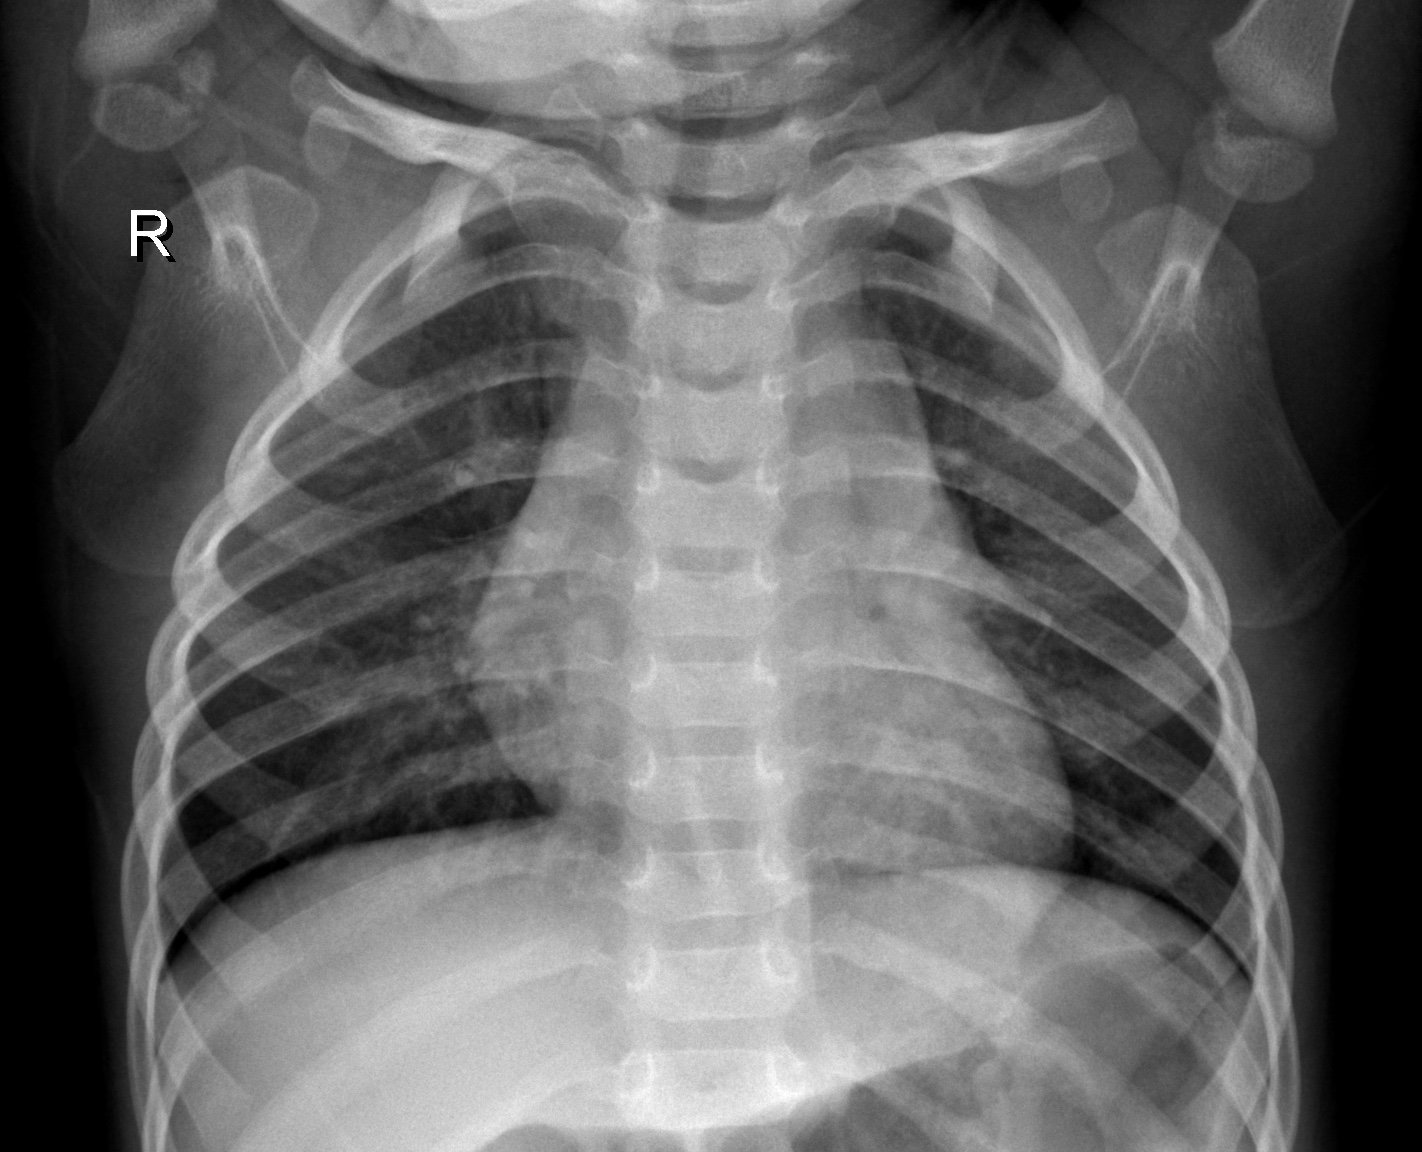

In [9]:
PIL.Image.open(train_norm_images[0])

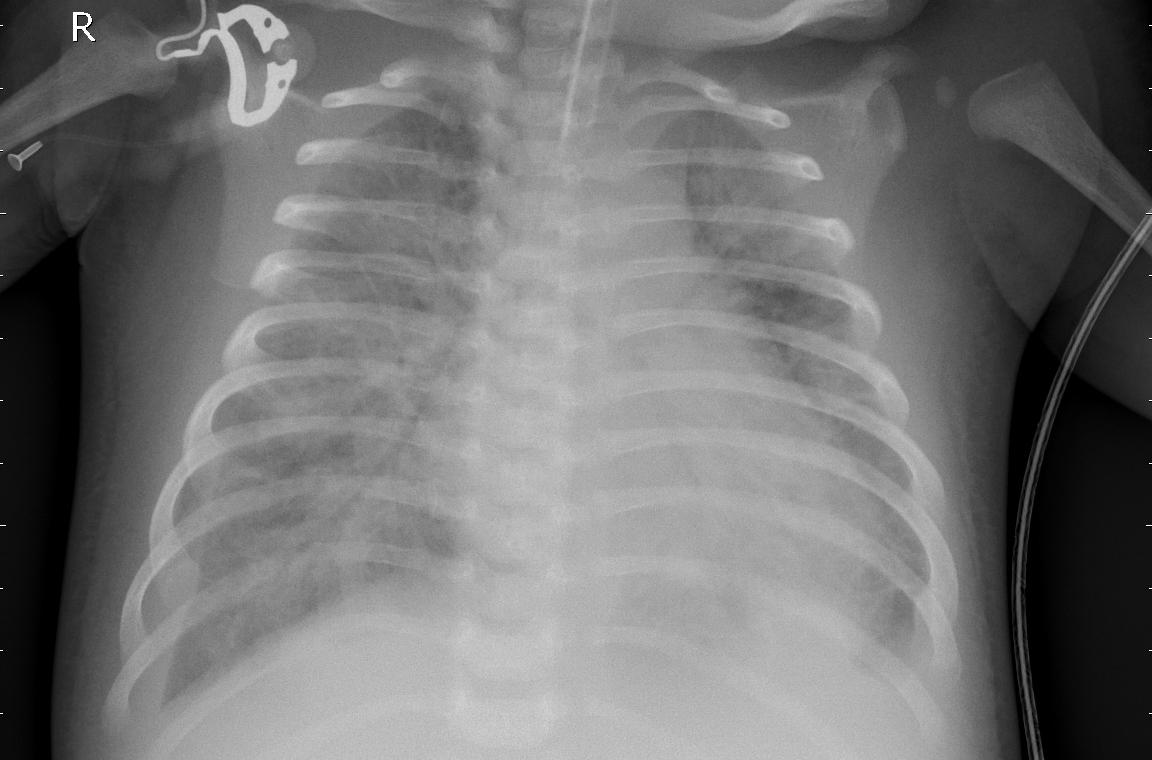

In [10]:
PIL.Image.open(train_pneu_images[0])

# Creating Test/Train Batches

In [11]:
# get all the data in the directory split/train (542 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255, 
                                     shear_range = 0.2, 
                                     zoom_range = 0.2, 
                                     width_shift_range=0.2,  
                                     height_shift_range=0.2, 
                                     rotation_range = 10
                                   ).flow_from_directory(train_dir,target_size=(256, 256), 
                                                         batch_size=4976,
                                                         class_mode='binary',
                                                         color_mode='grayscale')

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   rotation_range = 10
                                   ).flow_from_directory(val_dir,target_size=(256, 256), 
                                                         batch_size = 256,
                                                         class_mode='binary',
                                                         color_mode='grayscale')

# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    width_shift_range=0.2,  
                                    height_shift_range=0.2, 
                                    rotation_range = 10
                                    ).flow_from_directory(test_dir,target_size=(256, 256), 
                                                          batch_size = 624,
                                                         class_mode='binary',
                                                         color_mode='grayscale') 


Found 4976 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

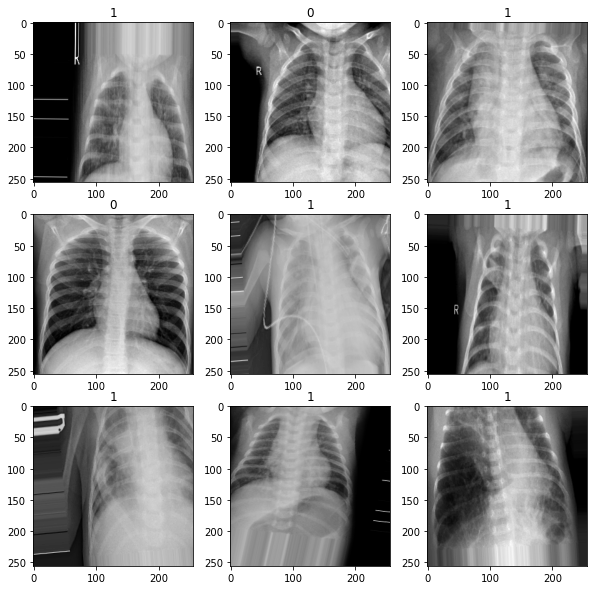

In [13]:
plt.figure(figsize=(10,10))

for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(array_to_img(train_images[i+250]), cmap='gray')
    plt.title(int(train_labels[i+250]));

In [14]:
# Exploring the dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4976
Number of testing samples: 624
Number of validation samples: 256
train_images shape: (4976, 256, 256, 1)
train_labels shape: (4976,)
test_images shape: (624, 256, 256, 1)
test_labels shape: (624,)
val_images shape: (256, 256, 256, 1)
val_labels shape: (256,)


In [15]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4976, 65536)
(624, 65536)
(256, 65536)


In [16]:
train_y = np.reshape(train_labels, (4976,1))
test_y = np.reshape(test_labels, (624,1))
val_y = np.reshape(val_labels, (256,1))

# Baseline Model

In [94]:
filepath = 'best_model_mlp_starter.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]

In [95]:
mlp_starter = models.Sequential()
mlp_starter.add(layers.Dense(20, activation='relu', input_shape=(12288,)))
mlp_starter.add(layers.Dense(7, activation='relu'))
mlp_starter.add(layers.Dense(5, activation='relu'))
mlp_starter.add(layers.Dense(1, activation='sigmoid'))

In [96]:
mlp_starter.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_mlp_starter = model.fit(train_img,
                    train_y,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(val_img, val_y),
                    callbacks=callbacks)

Epoch 1/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.6181 - accuracy: 0.6863 - val_loss: 0.8587 - val_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 0.85873, saving model to best_model_mlp_starter.hdf5
Epoch 2/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.7509 - val_loss: 0.8029 - val_accuracy: 0.5200

Epoch 00002: val_loss improved from 0.85873 to 0.80288, saving model to best_model_mlp_starter.hdf5
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.5286 - accuracy: 0.7509 - val_loss: 0.8336 - val_accuracy: 0.5200

Epoch 00003: val_loss did not improve from 0.80288
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.4949 - accuracy: 0.7509 - val_loss: 0.6823 - val_accuracy: 0.5200

Epoch 00004: val_loss improved from 0.80288 to 0.68226, saving model to best_model_mlp_starter.hdf5
Epoch 5/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.4508

In [97]:
results_test = mlp_starter.evaluate(test_img, test_y)

6/6 [==============================] - 0s 3ms/step - loss: 2.9870 - accuracy: 0.7167


In [98]:
mlp_starter.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 20)                245780    
_________________________________________________________________
dense_29 (Dense)             (None, 7)                 147       
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 40        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


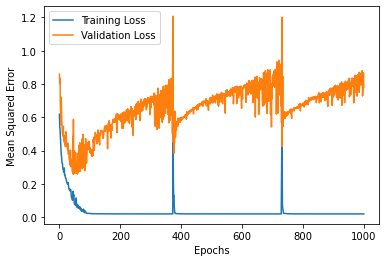

In [99]:
#plot the training history
plt.plot(history_mlp_starter.history['loss'], label='Training Loss')
plt.plot(history_mlp_starter.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [100]:
load_file = 'best_model_mlp_starter.hdf5'

In [101]:
best_model_mlp_starter = load_model(load_file)

In [102]:
best_model_mlp_starter.evaluate(test_img, test_y)

6/6 [==============================] - 0s 2ms/step - loss: 0.4383 - accuracy: 0.8333


[0.4382677674293518, 0.8333333134651184]

# A baseline CNN

In [103]:
filepath = 'best_model_cnn_starter.hdf5'

In [104]:
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

cnn1.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [105]:
history_cnn1 = model.fit(train_images,
                    train_y,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks)

Epoch 1/1000
17/17 [==============================] - 1s 14ms/step - loss: 0.6182 - acc: 0.7509 - val_loss: 0.9218 - val_acc: 0.5200

Epoch 00001: val_loss improved from inf to 0.92178, saving model to best_model_cnn_starter.hdf5
Epoch 2/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.5654 - acc: 0.7509 - val_loss: 0.7702 - val_acc: 0.5200

Epoch 00002: val_loss improved from 0.92178 to 0.77023, saving model to best_model_cnn_starter.hdf5
Epoch 3/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.5295 - acc: 0.7509 - val_loss: 0.6593 - val_acc: 0.5200

Epoch 00003: val_loss improved from 0.77023 to 0.65934, saving model to best_model_cnn_starter.hdf5
Epoch 4/1000
17/17 [==============================] - 0s 8ms/step - loss: 0.4393 - acc: 0.7897 - val_loss: 0.4385 - val_acc: 0.8250

Epoch 00004: val_loss improved from 0.65934 to 0.43853, saving model to best_model_cnn_starter.hdf5
Epoch 5/1000
17/17 [==============================] - 0s 8ms/step - los

In [106]:
results_test = cnn1.evaluate(test_images, test_y)

6/6 [==============================] - 0s 3ms/step - loss: 5.2563 - acc: 0.7611


In [107]:
cnn1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)            

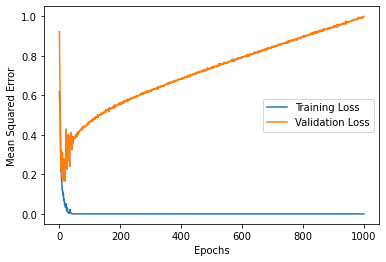

In [108]:
#plot the training history
plt.plot(history_cnn1.history['loss'], label='Training Loss')
plt.plot(history_cnn1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [109]:
load_file = 'best_model_cnn_starter.hdf5'

In [110]:
best_model_cnn_starter = load_model(load_file)

In [112]:
best_model_cnn_starter.evaluate(test_images, test_y)

6/6 [==============================] - 0s 4ms/step - loss: 0.7189 - acc: 0.7944


[0.7189265489578247, 0.7944444417953491]

### A Tuned CNN

In [17]:
filepath = 'best_model_cnn_hng.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callbacks = [checkpoint, reduce_lr]

In [20]:
cnn_hng = models.Sequential()
cnn_hng.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.MaxPooling2D((2, 2)))
cnn_hng.add(layers.Flatten())
cnn_hng.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_hng.add(layers.Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.001)
cnn_hng.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history_cnn_hng = cnn_hng.fit(train_images,
                    train_y,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks,
                    use_multiprocessing=True)

Epoch 1/1000
156/156 [==============================] - 11s 69ms/step - loss: 0.8736 - accuracy: 0.7653 - val_loss: 0.6062 - val_accuracy: 0.7734

Epoch 00001: val_loss improved from 0.75637 to 0.60618, saving model to best_model_cnn_hng.hdf5
Epoch 2/1000
156/156 [==============================] - 11s 68ms/step - loss: 0.4752 - accuracy: 0.7994 - val_loss: 0.5563 - val_accuracy: 0.8047

Epoch 00002: val_loss improved from 0.60618 to 0.55634, saving model to best_model_cnn_hng.hdf5
Epoch 3/1000
156/156 [==============================] - 11s 68ms/step - loss: 0.4186 - accuracy: 0.8330 - val_loss: 0.6152 - val_accuracy: 0.6211

Epoch 00003: val_loss did not improve from 0.55634
Epoch 4/1000
156/156 [==============================] - 11s 69ms/step - loss: 0.3648 - accuracy: 0.8708 - val_loss: 0.5400 - val_accuracy: 0.7695

Epoch 00004: val_loss improved from 0.55634 to 0.54004, saving model to best_model_cnn_hng.hdf5
Epoch 5/1000
156/156 [==============================] - 11s 69ms/step - l

In [22]:
results_test = cnn_hng.evaluate(test_images, test_y)

20/20 [==============================] - 1s 25ms/step - loss: 1.2905 - accuracy: 0.8205


In [23]:
cnn_hng.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)      

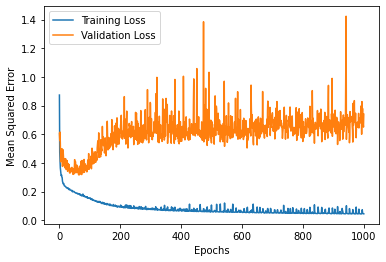

In [24]:
#plot the training history
plt.plot(history_cnn_hng.history['loss'], label='Training Loss')
plt.plot(history_cnn_hng.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

And now we'll look at the best iteration of the model.

In [18]:
load_file = 'best_model_cnn_hng.hdf5'

In [19]:
best_model_cnn_hng = load_model(load_file)

In [20]:
best_model_cnn_hng.evaluate(test_images, test_y)

20/20 [==============================] - 11s 36ms/step - loss: 0.5839 - accuracy: 0.8686


[0.583889365196228, 0.8685897588729858]

In [21]:
y_proba = best_model_cnn_hng.predict(test_images, batch_size=32, use_multiprocessing=True)

In [22]:
y_hat = np.round(y_proba)

In [23]:
cf_matrix = confusion_matrix(test_labels, y_hat)

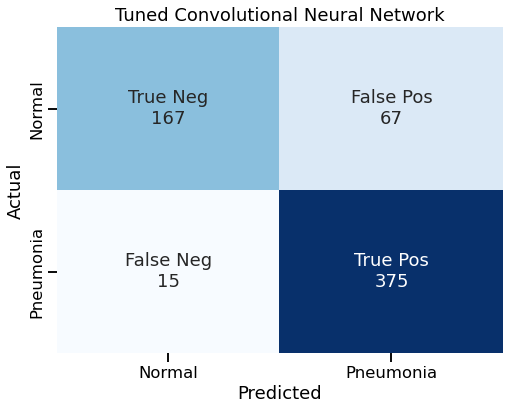

In [24]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Pneumonia']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cf_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Tuned Convolutional Neural Network')
fig.savefig('./graphs/tuned_cnn_confusion', dpi=300, transparent=False, bbox_inches='tight');

In [26]:
print(f'Recall:    {recall_score(test_labels, y_hat)}')
print(f'Precision: {precision_score(test_labels, y_hat)}')
print(f'Accuracy:  {accuracy_score(test_labels, y_hat)}')
print(f'F1 score:  {f1_score(test_labels, y_hat)}')
print(f'AUROC:     {roc_auc_score(test_labels, y_proba)}')

Recall:    0.9615384615384616
Precision: 0.8484162895927602
Accuracy:  0.8685897435897436
F1 score:  0.9014423076923077
AUROC:     0.9147874205566514


### Balancing our Classes on the same model

This model worked well, but our classes are imbalanced. We'll build an identical model but with the classes weighted properly to account for the imbalance.

In [27]:
filepath = 'best_model_cnn_mtt.hdf5'

In [28]:
normal= len(os.listdir(train_norm_dir))
pneumonia= len(os.listdir(train_pneu_dir))

train_count = normal + pneumonia
weight_for_0 = (1 / normal) * (train_count) / 2.0
weight_for_1 = (1 / pneumonia) * (train_count) / 2.0

weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 2.04
Weight for class 1: 0.66


In [19]:
cnn_mtt = models.Sequential()
cnn_mtt.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
cnn_mtt.add(layers.MaxPooling2D((2, 2)))
cnn_mtt.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_mtt.add(layers.MaxPooling2D((2, 2)))
cnn_mtt.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_mtt.add(layers.MaxPooling2D((2, 2)))
cnn_mtt.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_mtt.add(layers.MaxPooling2D((2, 2)))
cnn_mtt.add(layers.Flatten())
cnn_mtt.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn_mtt.add(layers.Dense(1, activation='sigmoid'))

adam = Adam(learning_rate=.001)
cnn_mtt.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
history_cnn_mtt = cnn_mtt.fit(train_images,
                    train_y,
                    epochs=1000,
                    batch_size=64,
                    validation_data=(val_images, val_y),
                    class_weight=weight,
                    callbacks=callbacks,
                    use_multiprocessing=True)

Epoch 1/1000
78/78 [==============================] - 10s 125ms/step - loss: 0.4346 - accuracy: 0.8515 - val_loss: 0.4555 - val_accuracy: 0.8438

Epoch 00001: val_loss improved from 0.50933 to 0.45553, saving model to best_model_cnn_mtt.hdf5
Epoch 2/1000
78/78 [==============================] - 10s 123ms/step - loss: 0.4005 - accuracy: 0.8637 - val_loss: 0.4205 - val_accuracy: 0.8555

Epoch 00002: val_loss improved from 0.45553 to 0.42050, saving model to best_model_cnn_mtt.hdf5
Epoch 3/1000
78/78 [==============================] - 10s 123ms/step - loss: 0.3741 - accuracy: 0.8730 - val_loss: 0.4218 - val_accuracy: 0.8555

Epoch 00003: val_loss did not improve from 0.42050
Epoch 4/1000
78/78 [==============================] - 10s 123ms/step - loss: 0.3730 - accuracy: 0.8670 - val_loss: 0.4391 - val_accuracy: 0.8555

Epoch 00004: val_loss did not improve from 0.42050
Epoch 5/1000
78/78 [==============================] - 10s 123ms/step - loss: 0.3617 - accuracy: 0.8706 - val_loss: 0.3970 

KeyboardInterrupt: 

### Interrupting the training

The above is not an error; we've merely halted the training because even after 500 epochs, we don't seem to be making much improvement. The model could improve eventually if we let it run for long enough, but our team only has so much GPU processing power to go around and we've decided to use allocate it to other models. We may return to this model if we have the time.

In [29]:
load_file = 'best_model_cnn_mtt.hdf5'

In [30]:
best_model_cnn_mtt = load_model(load_file)

In [31]:
y_proba = best_model_cnn_mtt.predict(test_images, batch_size=32, use_multiprocessing=True)

In [32]:
y_hat = np.round(y_proba)

In [33]:
cf_matrix = confusion_matrix(test_labels, y_hat)

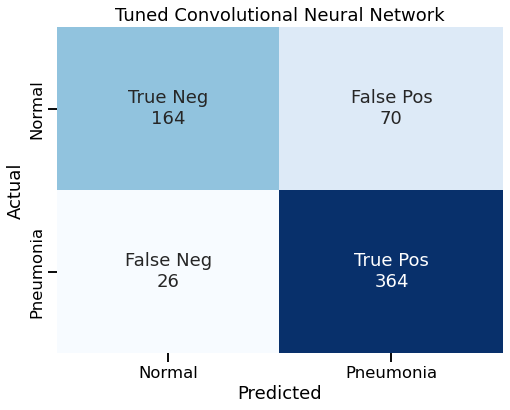

In [34]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Pneumonia']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cf_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Tuned Convolutional Neural Network')
fig.savefig('./graphs/tuned_cnn_confusion2', dpi=300, transparent=False, bbox_inches='tight');

In [35]:
print(f'Recall:    {recall_score(test_labels, y_hat)}')
print(f'Precision: {precision_score(test_labels, y_hat)}')
print(f'Accuracy:  {accuracy_score(test_labels, y_hat)}')
print(f'F1 score:  {f1_score(test_labels, y_hat)}')
print(f'AUROC:     {roc_auc_score(test_labels, y_proba)}')

Recall:    0.9333333333333333
Precision: 0.8387096774193549
Accuracy:  0.8461538461538461
F1 score:  0.883495145631068
AUROC:     0.9129520052596976


### DenseNet121

In [36]:
# Creating Densenet121

def densenet(input_shape, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
        
    x = GlobalAveragePooling2D()(d)
    output = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(input, output)
    return model

In [37]:
input_shape = 256, 256, 1

dense121 = densenet(input_shape)

In [38]:
filepath = 'best_model_dense121.hdf5'

In [20]:
adam = Adam(learning_rate=.001)
dense121.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
history_dense121 = dense121.fit(train_images,
                    train_y,
                    epochs=300,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks,
                    use_multiprocessing=True)

Epoch 1/300
156/156 [==============================] - 73s 466ms/step - loss: 0.1995 - accuracy: 0.9176 - val_loss: 1.2029 - val_accuracy: 0.5820

Epoch 00001: val_loss improved from 8.54718 to 1.20291, saving model to best_model_dense121.hdf5
Epoch 2/300
156/156 [==============================] - 73s 469ms/step - loss: 0.1851 - accuracy: 0.9214 - val_loss: 5.6996 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 1.20291
Epoch 3/300
156/156 [==============================] - 75s 479ms/step - loss: 0.2023 - accuracy: 0.9190 - val_loss: 4.6861 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.20291
Epoch 4/300
156/156 [==============================] - 75s 480ms/step - loss: 0.1656 - accuracy: 0.9381 - val_loss: 1.9027 - val_accuracy: 0.5156

Epoch 00004: val_loss did not improve from 1.20291
Epoch 5/300
156/156 [==============================] - 72s 464ms/step - loss: 0.1565 - accuracy: 0.9449 - val_loss: 37.8478 - val_accuracy: 0.5000

Epoch 00005: v

In [29]:
results_test = dense121.evaluate(test_images, test_y)

20/20 [==============================] - 3s 127ms/step - loss: 0.8505 - accuracy: 0.8574


In [30]:
dense121.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

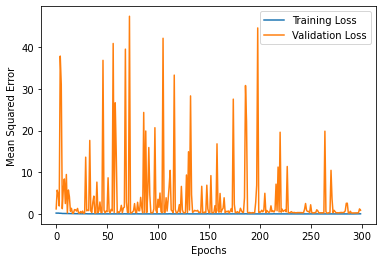

In [31]:
#plot the training history
plt.plot(history_dense121.history['loss'], label='Training Loss')
plt.plot(history_dense121.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('model_training_history')
plt.show()

In [39]:
load_file = 'best_model_dense121.hdf5'

In [40]:
best_model_dense121 = load_model(load_file)

In [41]:
best_model_dense121.evaluate(test_images, test_y)

20/20 [==============================] - 16s 160ms/step - loss: 0.6810 - accuracy: 0.8574


[0.6810137033462524, 0.8573718070983887]

It would be great if this model were performing better than our generic CNN, but we are training it from scratch, so it's somewhat understandable that it's not. We'll train for a bit more to see if we get any improvement.

In [35]:
history2_dense121 = dense121.fit(train_images,
                    train_y,
                    epochs=300,
                    batch_size=32,
                    validation_data=(val_images, val_y),
                    callbacks=callbacks,
                    use_multiprocessing=True)

Epoch 1/300
156/156 [==============================] - 69s 441ms/step - loss: 0.0050 - accuracy: 0.9982 - val_loss: 0.4511 - val_accuracy: 0.9414

Epoch 00001: val_loss did not improve from 0.15323
Epoch 2/300
156/156 [==============================] - 69s 441ms/step - loss: 8.1519e-04 - accuracy: 1.0000 - val_loss: 0.2251 - val_accuracy: 0.9570

Epoch 00002: val_loss did not improve from 0.15323
Epoch 3/300
156/156 [==============================] - 69s 443ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.2230 - val_accuracy: 0.9570

Epoch 00003: val_loss did not improve from 0.15323
Epoch 4/300
156/156 [==============================] - 69s 443ms/step - loss: 3.5920e-04 - accuracy: 1.0000 - val_loss: 0.2408 - val_accuracy: 0.9570

Epoch 00004: val_loss did not improve from 0.15323
Epoch 5/300
156/156 [==============================] - 69s 445ms/step - loss: 2.9732e-04 - accuracy: 1.0000 - val_loss: 0.4006 - val_accuracy: 0.9492

Epoch 00005: val_loss did not improve from 0.1532

KeyboardInterrupt: 

### Interrupting the training

Once again, we've halted the training because after 100 epochs, we don't seem to be making much improvement.

In [36]:
results_test = dense121.evaluate(test_images, test_y)

20/20 [==============================] - 2s 124ms/step - loss: 2.0241 - accuracy: 0.8397


In [42]:
load_file = 'best_model_dense121.hdf5'

In [43]:
best_model_dense121 = load_model(load_file)

In [44]:
best_model_dense121.evaluate(test_images, test_y)

20/20 [==============================] - 12s 123ms/step - loss: 0.6810 - accuracy: 0.8574


[0.6810137033462524, 0.8573718070983887]

In [45]:
y_proba = best_model_dense121.predict(test_images, batch_size=32, use_multiprocessing=True)

In [46]:
y_hat = np.round(y_proba)

In [47]:
cf_matrix = confusion_matrix(test_labels, y_hat)

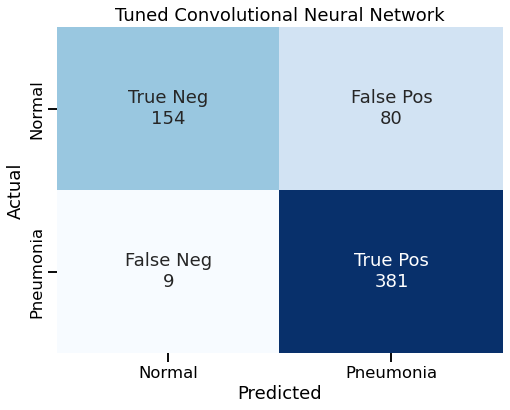

In [48]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Pneumonia']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cf_matrix, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Tuned Convolutional Neural Network')
fig.savefig('./graphs/densenet121', dpi=300, transparent=False, bbox_inches='tight');

In [50]:
print(f'Recall:    {recall_score(test_labels, y_hat)}')
print(f'Precision: {precision_score(test_labels, y_hat)}')
print(f'Accuracy:  {accuracy_score(test_labels, y_hat)}')
print(f'F1 score:  {f1_score(test_labels, y_hat)}')
print(f'AUROC:     {roc_auc_score(test_labels, y_proba)}')

Recall:    0.9769230769230769
Precision: 0.8264642082429501
Accuracy:  0.8573717948717948
F1 score:  0.8954171562867214
AUROC:     0.9556213017751479


So it seems that while our accuracy has gone down, our recall is up to 98%, which is quite good, particularly compared to human radiologists. This is to say that in terms of the False Negative rate, this model performs very well and would certainly be a candidate for deployment as our final model. However, because the precision is fairly poor, and because overprescription of antibiotics is a concern of ours, we likely can't recommend the use of this model.